In [1]:
import sys
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
from matplotlib.gridspec import GridSpec
import copy
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

from multiprocess import Pool, Manager

import numpy as np
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.integrate import quad
from IPython.display import display, Math
from scipy.interpolate import CubicSpline
import scipy as scipy
from tqdm import tqdm

import pickle

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting
from astropy.timeseries import LombScargle

import stingray.events as ev
import stingray.lightcurve as lc
from stingray import io
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
from stingray.pulse.search import phaseogram, plot_phaseogram, plot_profile, epoch_folding_search, z_n_search
from stingray.pulse.pulsar import fold_events, pulse_phase
import stingray.gti as sting_gti
import stingray.pulse.accelsearch as accelsearch
from stingray import stats
from stingray.deadtime import fad


sns.set_context('paper')
sns.set(font_scale=1.6)
sns.set_style("whitegrid")
sns.set_style({'axes.edgecolor': 'black', 'xtick.bottom': True, 'ytick.left': True,})
sns.set_palette("colorblind")

sys.path.insert(1, '/Users/sean/scripts/helpers')

### Orbital parameters from Mazzola+2019 Quadratic model (Table 2)
# T0 = -418427654.688 # MJD 50353.08733
# P0 = 0.2321095653 * 3600.*24. 
# Pdot = 1.475e-10 
# Pdotdot = 0.0 

# T0_err = 14.
# P0_err = 0.000734
# Pdot_err = 0.054e-10 
# Pdotdot_err = 0.0 

### Orbital parameters from Mazzola+2019 Cubic model (Table 2)
T0 = -418427661.600 # MJD 50353.08725
P0 = 0.2321095653 * 3600.*24. 
Pdot = 1.475e-10 
Pdotdot = -0.91e-19

T0_err = 14.
P0_err = 0.0015552
Pdot_err = 0.055e-10 
Pdotdot_err = 0.55e-19


### asin(i)/c from Jonker and van der Klis 2001
asini_over_c = 1.006 # light-seconds, error 0.005
asini_over_c_err = 0.005


from stingray_plus import *

def orbit_correct(t, t0, p0, pdot0, pdotdot0, asini_over_c):
    return t + asini_over_c*np.sin((-np.pi/2.) + (2.*np.pi/p0)*((t-t0)-((pdot0/(2.*p0))*np.square(t-t0)) - ((pdotdot0/(6.*p0))*np.power(t-t0,3))))

root_dir = '/Users/sean/astro/4U_1822m37/'

/Users/sean/opt/miniconda3/lib/python3.9/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")


In [2]:
OBSID='30701025002'

pipeline_dir = root_dir + OBSID + '_pipe_out/'
plot_dir = root_dir + 'figures/'

# Calculate the FAD and Z_n search

In [3]:
events = extract_events(pipeline_dir + 'nu' + OBSID + 'A01_cl_bc_regfilt_3-78keV.evt', pipeline_dir + 'nu' + OBSID + 'B01_cl_bc_regfilt_3-78keV.evt')
energy_mask_A = (events[0].pi >= eV_to_PI(10000)) * (events[0].pi <= eV_to_PI(50000))
energy_mask_B = (events[1].pi >= eV_to_PI(10000)) * (events[1].pi <= eV_to_PI(50000))
all_times = np.sort(np.concatenate([events[0].time[energy_mask_A], events[1].time[energy_mask_B]]))
# all_times = np.sort(np.concatenate([events[0].time, events[1].time]))
print(np.min(all_times))
print(np.max(all_times))

382609599.72058475
382803612.0146303


In [14]:
fad_pds = fad.FAD(events[0], events[1], segment_size=2048., dt=1.0/1024., norm='frac', return_objects=True)['ptot']
pickle.dump(fad_pds, open(pipeline_dir + 'FAD_ptot_rms_10-50keV.txt', 'wb'))
# fad_pds = pickle.load(open(pipeline_dir + 'FAD_ptot_rms.txt', 'rb'))
# print(fad_pds.freq[:5])

5it [02:42, 32.42s/it]


In [15]:
if fad_pds.norm == 'frac':
    fad_pds.power_err = fad_pds.power/np.sqrt(fad_pds.m)
elif fad_pds.norm == 'leahy':
    fad_pds.power_err = fad_pds.power/np.sqrt(fad_pds.m/2.)
# pickle.dump(fad_pds, open(pipeline_dir + 'FAD_ptot_Leahy.txt', 'wb'))
# print(fad_pds.df/2)
# print(fad_pds.freq)
log_pds = fad_pds.rebin_log(f=0.005)
if fad_pds.norm =='leahy':
    p_noise = 2.0
else:
    p_noise = np.mean(fad_pds.power[fad_pds.freq>10.])
print(p_noise)

0.06506160901798527


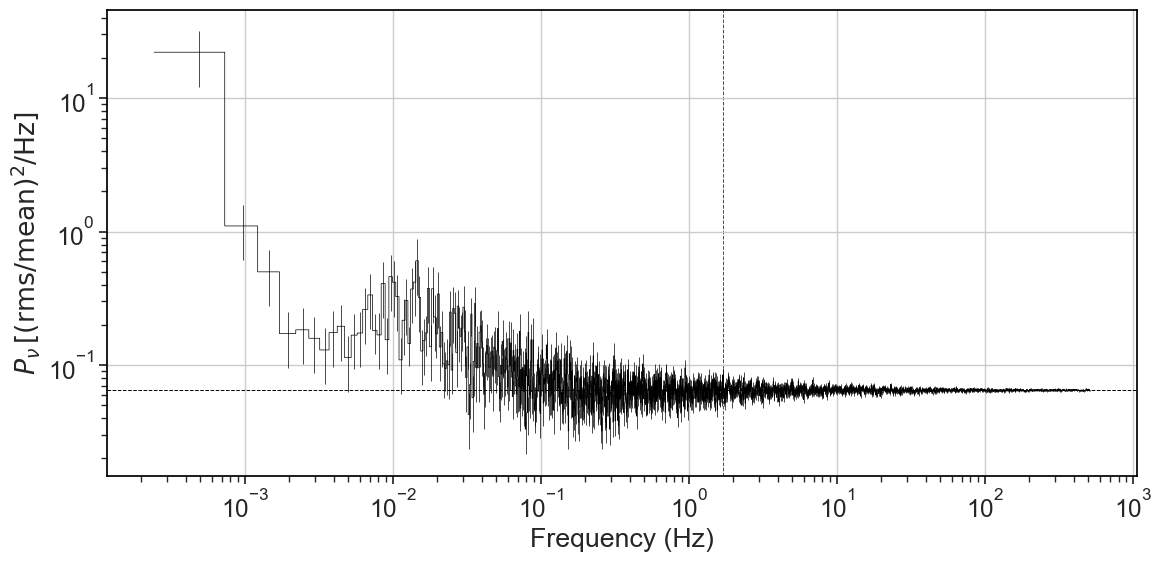

In [16]:
plt.figure(figsize=(12,6))
plt.errorbar(log_pds.freq, log_pds.power, yerr=log_pds.power_err, \
                     fmt='none', color='black', lw=0.5, rasterized=False)
plt.step(np.concatenate([[log_pds.freq[0]-log_pds.df/2.], log_pds.freq]), np.concatenate([[log_pds.power[0]], log_pds.power]), where='mid', color='black', lw=0.5, rasterized=False)

plt.axhline(p_noise, color='black', ls='--', lw=0.7)
plt.axvline(1/0.59, color='red', ls='--', lw=0.7, zorder=0)
    
plt.loglog()
plt.xlabel('Frequency (Hz)')

if fad_pds.norm =='leahy':
    plt.ylabel('Leahy Power')
else:
    plt.ylabel(r'$P_{\nu}\,[\mathrm{(rms/mean)^{2}/Hz}]$')
plt.tight_layout()
plt.savefig(plot_dir + OBSID + '_FAD_ptot_rms_10-50keV.pdf')

In [25]:
temp_sum = 0
for g in events[0].gti:
    temp_sum += (g[1]-g[0])>1000.
print(temp_sum)

21


In [4]:
# ### TODO: Sort z_n_max by parameters to get parameter errors?

# ### Search Mazzola orbital parameter space to try to maximize the Z_n statistic
random_params = np.random.default_rng().normal(size=(100000, 5), loc=[T0, P0, Pdot, Pdotdot, asini_over_c], \
                                               scale=[T0_err, P0_err, Pdot_err, Pdotdot_err, asini_over_c_err])
print(random_params)
search_freqs = np.linspace(1/0.59118265, 1/0.59113825, 127)

# def orbit_correct_mp(t0, p0, pdot0, pdotdot0, asini_over_c):
#     t = all_times
#     return t + asini_over_c*np.sin((np.pi/2.) + (2.*np.pi/p0)*((t-t0)-((pdot0/(2.*p0))*np.square(t-t0)) - ((pdotdot0/(6.*p0))*np.power(t-t0,3))))

# with Pool(8) as p:
#     z_n_max = p.starmap(orbit_correct_mp, random_params)

z_n_max = []
for params in tqdm(random_params):
    fgrid, z_n_stats = z_n_search(orbit_correct(all_times, *params), frequencies=search_freqs, nharm=1)
    z_n_max.append(np.max(z_n_stats))
    
pickle.dump([random_params, z_n_max], open(pipeline_dir + 'orbital_param_zn_scan.txt', 'wb'))

[[-4.18427637e+08  2.00542665e+04  1.51612377e-10 -4.22222856e-20
   1.01348547e+00]
 [-4.18427653e+08  2.00542656e+04  1.48151173e-10 -1.83823211e-20
   1.00768119e+00]
 [-4.18427656e+08  2.00542647e+04  1.47190182e-10 -1.26779171e-19
   1.00406818e+00]
 ...
 [-4.18427667e+08  2.00542677e+04  1.55985139e-10 -9.93552367e-20
   1.00594949e+00]
 [-4.18427641e+08  2.00542657e+04  1.46242632e-10 -9.99032491e-20
   1.00351428e+00]
 [-4.18427655e+08  2.00542680e+04  1.39174104e-10 -2.11053432e-20
   1.01360888e+00]]


100%|████████████████████████████████| 100000/100000 [28:43:28<00:00,  1.03s/it]


[-4.18427654e+08  2.00542661e+04  1.51419708e-10 -6.88747341e-20
  1.02581862e+00]


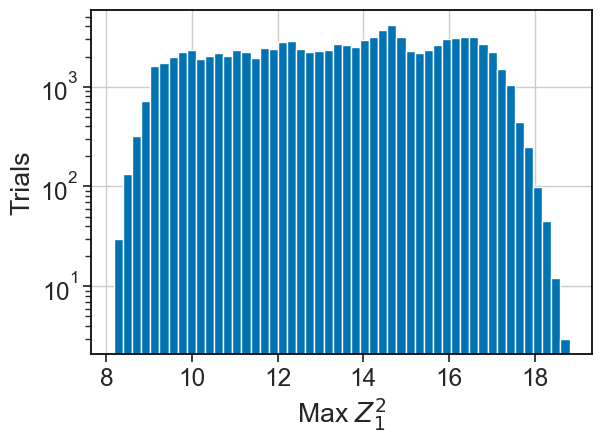

In [5]:
plt.figure()
plt.hist(z_n_max, bins=50)
plt.yscale('log')
plt.ylabel('Trials')
plt.xlabel('Max ' + r'$Z^2_1$')
plt.tight_layout()
plt.savefig(plot_dir+'orbit_search.pdf')
print(random_params[np.argmax(z_n_max)])

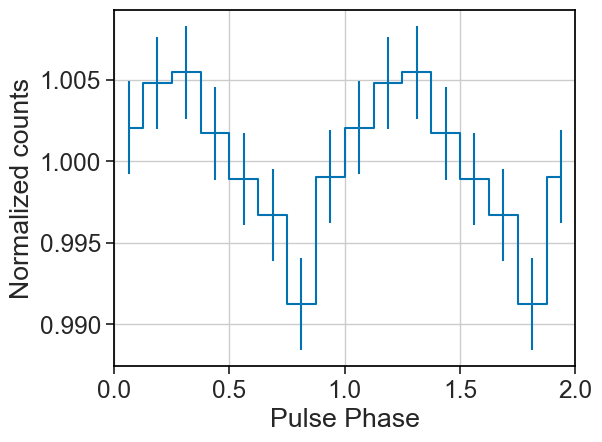

0.5911428011483533
[ 3.98756609e-05  3.02040589e-07  3.00664168e-07  2.93821527e-07
 -4.24910302e-07 -4.37453867e-07 -4.39828004e-07]


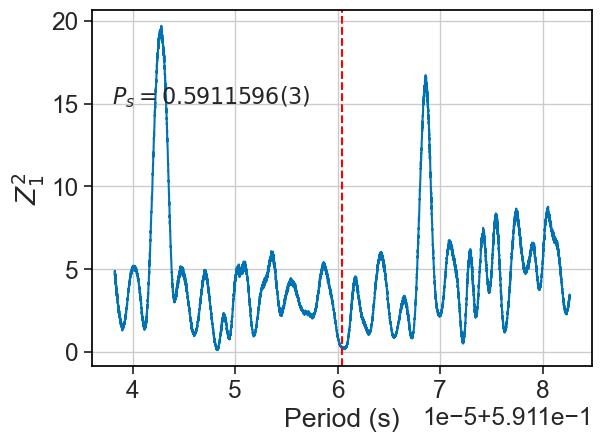

0.7125005569575132 +/- 0.20125591829402883
0.0005727433200865508


In [15]:
nharm = 2
search_freqs = np.linspace(1/0.59118265, 1/0.59113825, 10000)
fgrid, z_n_stats = z_n_search(orbit_correct(all_times, *(random_params[np.argmax(z_n_max)])), frequencies=search_freqs, nharm=nharm)
# fgrid, z_n_stats = z_n_search(orbit_correct(all_times, T0, P0, Pdot, Pdotdot, asini_over_c), frequencies=search_freqs, nharm=nharm)

rolln = 4
plt.figure()
phase_bins, profile, profile_err = fold_events(orbit_correct(all_times, *(random_params[np.argmax(z_n_max)])), fgrid[np.argmax(z_n_stats)], nbin=8)
plt.errorbar(np.concatenate([phase_bins, phase_bins+1]), np.roll(np.concatenate([profile,profile]), rolln)/np.mean(profile), yerr=np.roll(np.concatenate([profile_err, profile_err]), rolln)/np.mean(profile), fmt='', ls='', color='C0')
plt.step(np.concatenate([phase_bins, phase_bins+1]), np.roll(np.concatenate([profile,profile]), rolln)/np.mean(profile), where='mid', color='C0')
plt.ylabel('Normalized counts')
plt.xlabel('Pulse Phase')
plt.xlim(0.,2.)
plt.tight_layout()
plt.savefig(plot_dir + 'pulse_profile_10-50keV_searchparams_nharm2.pdf')
plt.show()
plt.close()

# plt.figure()
# phase_bins, profile, profile_err = fold_events(orbit_correct(all_times, *(random_params[np.argmax(z_n_max)])), 0.5910290297724867, nbin=32)
# plt.errorbar(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), yerr=np.concatenate([profile_err, profile_err])/np.mean(profile), fmt='', ls='', color='C0')
# plt.step(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), where='mid', color='C0')
# plt.ylabel('Normalized counts')
# plt.xlabel('Pulse Phase')
# plt.xlim(0.,2.)
# plt.tight_layout()
# plt.show()
# plt.close()

print(1/fgrid[np.argmax(z_n_stats)])


# split_len = 2000
# for g in events[0].gti:
#     if g[1]-g[0] > 1000:
#         i=0
#         while g[0]+(split_len*i) < g[1] - split_len:
#             time_mask = (all_times >= g[0]+(split_len*i)) * (all_times <=g[0]+(split_len*(i+1)))
#             fgrid, z_n_stats = z_n_search(orbit_correct(all_times[time_mask], *(random_params[np.argmax(z_n_max)])), frequencies=search_freqs, nharm=1)
#             plt.figure()
#             plt.plot(1/fgrid, z_n_stats)
#             # plt.plot(fgrid[fit_mask], spline(fgrid[fit_mask]))
#             plt.show()
#             plt.close()
            
#             plt.figure()
#             phase_bins, profile, profile_err = fold_events(orbit_correct(all_times[time_mask], *(random_params[np.argmax(z_n_max)])), fgrid[np.argmax(z_n_stats)], nbin=32)
#             plt.errorbar(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), yerr=np.concatenate([profile_err, profile_err])/np.mean(profile), fmt='', ls='', color='C0')
#             plt.step(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), where='mid', color='C0')
#             plt.ylabel('Normalized counts')
#             plt.xlabel('Pulse Phase')
#             plt.xlim(0.,2.)
#             plt.tight_layout()
#             plt.show()
#             plt.close()

#             i+=1

# for g in events[0].gti:
#     if g[1]-g[0] > 1000:
#         time_mask = (all_times >= g[0]) * (all_times <=g[1])
#         fgrid, z_n_stats = z_n_search(orbit_correct(all_times[time_mask], *(random_params[np.argmax(z_n_max)])), frequencies=search_freqs, nharm=1)
#         plt.figure()
#         plt.plot(1/fgrid, z_n_stats)
#         # plt.plot(fgrid[fit_mask], spline(fgrid[fit_mask]))
#         plt.show()
#         plt.close()

#         plt.figure()
#         phase_bins, profile, profile_err = fold_events(orbit_correct(all_times[time_mask], *(random_params[np.argmax(z_n_max)])), fgrid[np.argmax(z_n_stats)], nbin=32)
#         plt.errorbar(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), yerr=np.concatenate([profile_err, profile_err])/np.mean(profile), fmt='', ls='', color='C0')
#         plt.step(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), where='mid', color='C0')
#         plt.ylabel('Normalized counts')
#         plt.xlabel('Pulse Phase')
#         plt.xlim(0.,2.)
#         plt.tight_layout()
#         plt.show()
#         plt.close()

#             i+=1


# print(search_freqs)

# fit_mask = (fgrid < 0.000892) * (fgrid > 0.00088)
# popt, pcov = curve_fit(gaussian,fgrid[fit_mask],z_n_stats[fit_mask],p0=[20000, 0.00090,0.00003])

chi_sq_sigma=2.27887
chi_sq_ninety=4.60517

# spline = CubicSpline(fgrid, z_n_stats)
# roots = spline.derivative().roots()
# nu_1 = roots[(0.5911596432268236- < roots) * (roots<0.5911596432268236)]
# print(nu_1)
roots = CubicSpline(fgrid, z_n_stats - np.max(z_n_stats) + chi_sq_sigma).roots()
nu_1_err = 1/roots - (1/fgrid[np.argmax(z_n_stats)])
print(nu_1_err)

# roots = CubicSpline(fgrid, z_n_stats - np.max(z_n_stats) + chi_sq_ninety).roots()
# nu_1_err = roots - fgrid[np.argmax(z_n_stats)]
# print(nu_1_err)

plt.figure()
plt.plot(1/fgrid, z_n_stats)
# plt.plot(fgrid[fit_mask], spline(fgrid[fit_mask]))
plt.axvline(0.59116044, color='red', ls='--', label='Ma')
# plt.plot(1/fgrid, one_sigma, color='blue', ls='dotted', lw=1.0)
# plt.plot(1/fgrid, two_sigma, color='green', ls='dotted', lw=1.0)
# plt.plot(1/fgrid, three_sigma, color='red', ls='dotted', lw=1.0)
plt.text(0.591138, 15, r'$P_s=0.5911596(3)$', fontsize=16)
plt.ylabel(r'$Z^2_1$')
plt.xlabel('Period (s)')
plt.tight_layout()
plt.savefig(plot_dir + 'z_search_10-50keV.pdf')
plt.show()
plt.close()


# plt.figure()
# plt.plot(fgrid, z_n_stats)
# # plt.plot(fgrid[fit_mask], spline(fgrid[fit_mask]))
# plt.axvline(1/0.59, color='red', zorder=0)

# spline = CubicSpline(np.flip(1/fgrid), np.flip(z_n_stats))
# roots = spline.derivative().roots()
# p_1 = roots[(1/0.000884 > roots) * (roots>1/0.0008875)]
# print(p_1)
# roots = CubicSpline(np.sort(1/fgrid), (np.flip(z_n_stats) - spline(p_1) + 13.3616)).roots()
# p_1_err = roots[(1/0.000884 > roots) * (roots>1/0.0008875)] - p_1
# print(p_1_err)

# plt.figure()
# phase_bins, profile, profile_err = fold_events(half_times_1, nu_1, nbin=128)
# plt.errorbar(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), yerr=np.concatenate([profile_err, profile_err])/np.mean(profile), fmt='', ls='', color='C0')
# plt.step(np.concatenate([phase_bins, phase_bins+1]), np.concatenate([profile,profile])/np.mean(profile), where='mid', color='C0')
# plt.ylabel('Normalized counts')
# plt.xlabel('Pulse Phase')
# plt.xlim(0.,2.)
# plt.tight_layout()
# # plt.savefig(plot_dir + OBSID + '_pulseprofile_4harm.pdf')

print(str(PF(profile)*100) + ' +/- ' + str(PF_err(profile, profile_err)*100))
print(stats.z2_n_probability(np.max(z_n_stats), nharm, ntrial=1))

[0.59113831 0.59116043 0.59118274]
0.5911604313642044


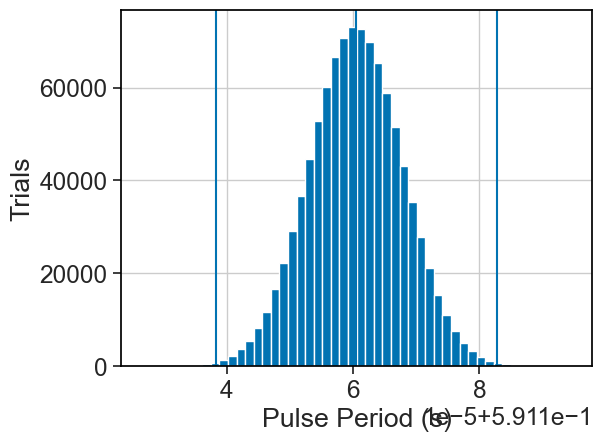

[0.59115304 0.59116043 0.59116783]


In [44]:
###from Mazzola et al. 2019
random_spin = np.random.default_rng().normal(loc=0.592758, scale = 0.000003, size=1000000) - \
                (np.random.default_rng().normal(loc=2.595, scale = 0.011, size=1000000)*(59625.34802083-52500.)*86400e-12)
                 
plt.hist(random_spin, bins = 50)

print(np.quantile(random_spin, [0.00135, 0.5, 0.99865]))
for quantile in np.quantile(random_spin, [0.00135, 0.5, 0.99865]):
    plt.axvline(quantile)
print(np.mean(random_spin))
plt.xlabel('Pulse Period (s)')
plt.ylabel('Trials')
plt.tight_layout()
plt.savefig(plot_dir + 'Mazzola_pdist.pdf')
plt.show()
plt.close()

print(np.quantile(random_spin, [0.1587, 0.5, 0.8413]))

In [78]:
stat_list = np.linspace(0.0, 20., 1000)
one_sigma = []
two_sigma = []
three_sigma = []
total_time = 0.
time_steps = []
for g in events[0].gti:
    total_time += g[1] - g[0]
    time_steps.append(np.arange(g[0], g[1], 1e-3))

time_steps = np.concatenate(time_steps)
sim_rate = (1.0 + 0.01*np.cos(time_steps*2.*np.pi/0.59116043)) * len(all_times)*1e-3/total_time
print(len(time_steps))

for i in range(10000):
    sim_times = np.random.
    
# for p in 1./fgrid: 
#     posterior = scipy.stats.norm.pdf(p, loc=0.59116043, scale=0.0000074) * (1.0-stats.z2_n_probability(stat_list, n=1, ntrial=len(search_freqs)))/stats.z2_n_probability(stat_list, n=1, ntrial=len(search_freqs))
#     spline = CubicSpline(stat_list, posterior - 0.9973)
#     roots = spline.roots()
#     three_sigma.append(roots)
#     spline = CubicSpline(stat_list, posterior - 0.6827)
#     roots = spline.roots()
#     one_sigma.append(roots)
#     spline = CubicSpline(stat_list, posterior - 0.9545)
#     roots = spline.roots()
#     two_sigma.append(roots)
    

109429343


38430.2908519272


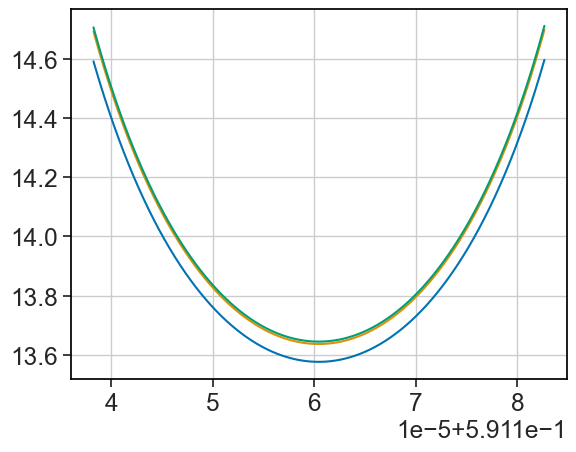

In [75]:
plt.figure()
plt.plot(1/fgrid, one_sigma)
plt.plot(1/fgrid, two_sigma)
plt.plot(1/fgrid, three_sigma)
posterior = scipy.stats.norm.pdf(0.5911596432268236, loc=0.59116043, scale=0.0000074) * \
        (1.0-stats.z2_n_probability(np.max(z_n_stats), n=1, ntrial=len(search_freqs)))/stats.z2_n_probability(np.max(z_n_stats), n=1, ntrial=len(search_freqs))
print(posterior)